# 3. Aprendizado Não Supervisionado - Tech Challenge Fase 3

Neste notebook, aplicaremos técnicas de **PCA** e **Clustering (K-Means)** para encontrar padrões ocultos nos dados.

**Objetivos:**
1. Reduzir a dimensionalidade com PCA para visualização.
2. Encontrar grupos naturais (clusters) de voos.
3. Interpretar o perfil de cada cluster.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Carga dos Dados Processados

In [2]:
try:
    df = pd.read_csv('flights_ml_ready.csv')
    print(f"Dataset carregado! Shape: {df.shape}")
except FileNotFoundError:
    print("ERRO: Arquivo 'flights_ml_ready.csv' não encontrado. Rode o notebook 2 primeiro.")

# Separando Features (X) para o não supervisionado
# Vamos usar apenas as variáveis numéricas principais para o clustering fazer sentido físico
cols_cluster = ['DISTANCE', 'SCHEDULED_TIME', 'DEPARTURE_DELAY']
X = df[cols_cluster].values

# Como já escalonamos no notebook anterior, podemos usar direto. 
# Mas por segurança, vamos garantir que X esteja escalonado aqui também (caso tenha sido salvo sem scaling)
# O notebook 2 salvou escalonado, mas é boa prática conferir. 
# Vamos re-escalonar para garantir (StandardScaler é rápido).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset carregado! Shape: (100000, 12)


## 2. PCA (Análise de Componentes Principais)
Vamos reduzir para 2 componentes para visualizar os dados em um gráfico de dispersão.

Variância explicada por cada componente: [0.66202322 0.33280812]
Variância total explicada: 0.99


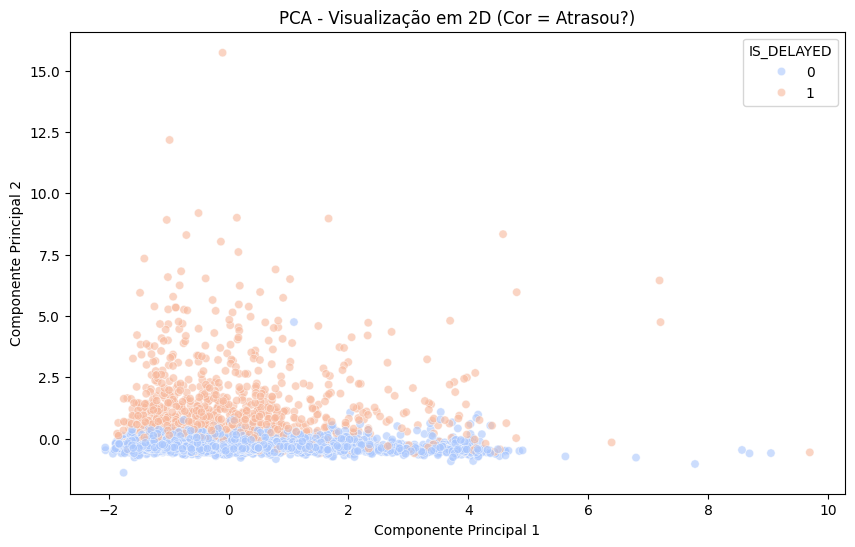

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.2f}")

# Visualizando
plt.figure(figsize=(10, 6))
# Usando uma amostra de 5000 pontos para não travar o plot
sns.scatterplot(x=X_pca[:5000, 0], y=X_pca[:5000, 1], hue=df['IS_DELAYED'][:5000], alpha=0.6, palette='coolwarm')
plt.title('PCA - Visualização em 2D (Cor = Atrasou?)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## 3. K-Means Clustering
Vamos usar o **Método do Cotovelo (Elbow Method)** para decidir o número de clusters (K).

Calculando inércia para diferentes K...


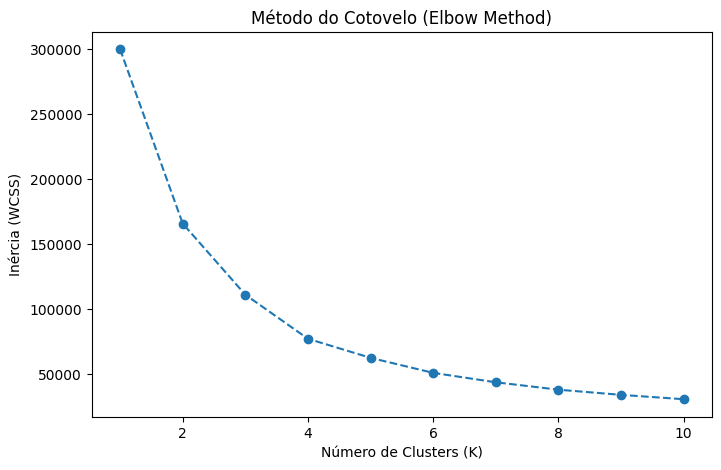

In [4]:
wcss = []
K_range = range(1, 11)

print("Calculando inércia para diferentes K...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.show()

### Escolha de K e Aplicação
Baseado no gráfico (provavelmente o cotovelo estará em 3 ou 4), vamos escolher K=4 para segmentar bem os perfis.

In [5]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Adicionando o cluster ao dataframe original para interpretação
df['CLUSTER'] = clusters

print("Contagem por Cluster:")
print(df['CLUSTER'].value_counts())

Contagem por Cluster:
CLUSTER
1    52442
3    32277
0    11615
2     3666
Name: count, dtype: int64


## 4. Interpretação dos Clusters
Vamos entender quem é quem. Vamos calcular a média das variáveis originais (desescalonadas) para cada cluster.

,DISTANCE,SCHEDULED_TIME,DEPARTURE_DELAY,IS_DELAYED
CLUSTER,,,,
0,2.15,2.12,-0.07,0.17
1,-0.69,-0.70,-0.17,0.14
2,-0.12,-0.10,3.87,1.00
3,0.37,0.38,-0.13,0.15


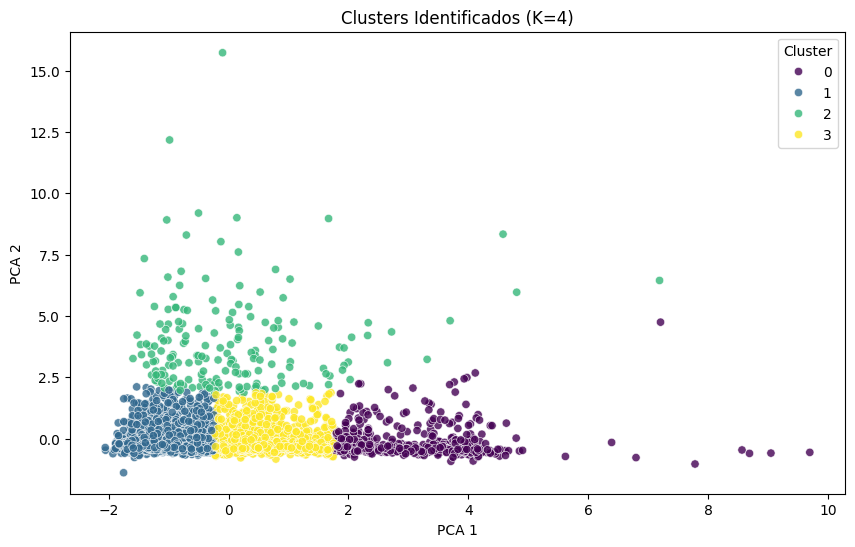

In [6]:
# Como os dados em 'df' estão escalonados nas colunas numéricas, 
# precisamos olhar para os valores relativos (Z-score) para interpretar.
# Valor > 0 significa acima da média, < 0 abaixo da média.

perfil_cluster = df.groupby('CLUSTER')[cols_cluster + ['IS_DELAYED']].mean()
display(perfil_cluster)

# Visualização dos Clusters no espaço do PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:5000, 0], y=X_pca[:5000, 1], hue=clusters[:5000], palette='viridis', alpha=0.8)
plt.title(f'Clusters Identificados (K={k_final})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()